## Imports ##

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor



import pandas as pd
import pickle
import numpy as np

#### Datasets

In [2]:
x_train_cell_lines = pd.read_csv('data/splits/train/x_train_cell_lines.csv', index_col=0)
x_train_drugs = pd.read_csv('data/splits/train/x_train_drugs.csv', index_col=0)
y_train = pd.read_csv('data/splits/train/y_train.csv', index_col=0)

x_test_cell_lines = pd.read_csv('data/splits/test/x_test_cell_lines.csv', index_col=0)
x_test_drugs = pd.read_csv('data/splits/test/x_test_drugs.csv', index_col=0)
y_test = pd.read_csv('data/splits/test/y_test.csv', index_col=0)

x_val_cell_lines = pd.read_csv('data/splits/val/x_val_cell_lines.csv', index_col=0)
x_val_drugs = pd.read_csv('data/splits/val/x_val_drugs.csv', index_col=0)
y_val = pd.read_csv('data/splits/val/y_val.csv', index_col=0)

### Merge data

In [3]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

x_train_drugs['Drug'] = x_train_drugs['Drug'].apply(smiles_to_fingerprint)
x_test_drugs['Drug'] = x_test_drugs['Drug'].apply(smiles_to_fingerprint)
x_val_drugs['Drug'] = x_val_drugs['Drug'].apply(smiles_to_fingerprint)

In [4]:
x_train_drugs

,Drug
Dabrafenib_SW1710,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
Lapatinib_TGW,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
Ruxolitinib_GCT,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
MN-64_EW-24,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Sapitinib_NCI-H1869,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
PFI3_SW1463,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
I-BRD9_SW1710,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Olaparib_RERF-GC-1B,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Crizotinib_HCC2218,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
x_train_drugs = pd.concat([x_train_drugs.drop(['Drug'], axis=1), x_train_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_test_drugs = pd.concat([x_test_drugs.drop(['Drug'], axis=1), x_test_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_val_drugs = pd.concat([x_val_drugs.drop(['Drug'], axis=1), x_val_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)

In [6]:
x_train_drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
Dabrafenib_SW1710,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
Lapatinib_TGW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ruxolitinib_GCT,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
MN-64_EW-24,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sapitinib_NCI-H1869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFI3_SW1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
I-BRD9_SW1710,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
Olaparib_RERF-GC-1B,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Crizotinib_HCC2218,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

# Machine learning Models

In [8]:
# merge drug and cell lines
x_train = pd.concat([x_train_cell_lines, x_train_drugs], axis=1)
x_test = pd.concat([x_test_cell_lines, x_test_drugs], axis=1)
x_val = pd.concat([x_val_cell_lines, x_val_drugs], axis=1)


In [14]:
x_train

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
Dabrafenib_SW1710,7.920898,5.369301,3.820045,2.893578,10.140094,2.888785,4.808708,3.838261,5.110550,5.442045,...,0,0,0,0,0,0,0,1,0,0
Lapatinib_TGW,4.086446,6.715755,3.152207,2.977787,11.495806,2.832806,5.748287,2.788454,3.656858,6.440322,...,0,0,0,0,0,0,0,0,0,0
Ruxolitinib_GCT,8.272114,5.417548,3.558538,3.053982,11.082245,2.823397,6.046880,4.953580,5.376569,5.403302,...,0,0,0,0,0,1,0,0,0,0
MN-64_EW-24,3.324724,4.391741,3.439392,6.849185,11.444114,3.069665,5.608626,2.964643,4.407107,6.767137,...,0,0,0,0,0,0,0,0,0,0
Sapitinib_NCI-H1869,7.296754,8.546812,3.664518,3.362914,10.627687,3.029736,4.349724,3.369286,4.738751,5.501484,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFI3_SW1463,7.851452,6.143533,3.774689,2.937680,11.339133,3.043644,4.580882,5.089882,3.330522,5.595879,...,0,0,0,0,0,1,0,0,0,0
I-BRD9_SW1710,7.920898,5.369301,3.820045,2.893578,10.140094,2.888785,4.808708,3.838261,5.110550,5.442045,...,0,1,0,0,0,1,0,0,0,0
Olaparib_RERF-GC-1B,7.103327,6.057814,3.285193,2.881877,11.527119,2.978740,5.526652,3.157037,4.615804,6.645393,...,0,0,0,0,0,1,0,0,0,0
Crizotinib_HCC2218,7.205591,5.356177,3.342622,2.919920,11.388315,3.095454,4.328444,3.060736,3.731668,5.786437,...,0,0,0,0,0,1,0,0,0,0


### linear

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True, positive=False)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred_lr))
print('MSE: ', mean_squared_error(y_test, y_pred_lr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('R2: ', r2_score(y_test, y_pred_lr))







Linear Regression
MAE:  0.8845281548951429
MSE:  1.4137157356447514
RMSE:  1.1889977862236545
R2:  0.8137075172310488


In [11]:
# grid search with linear regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


param_grid = {'fit_intercept':[True,False]}


grid = GridSearchCV(LinearRegression() ,param_grid, cv=5, verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ................fit_intercept=True;, score=0.811 total time=  36.1s
[CV 2/5] END ................fit_intercept=True;, score=0.816 total time=  35.2s
[CV 3/5] END ................fit_intercept=True;, score=0.805 total time=  34.4s
[CV 4/5] END ................fit_intercept=True;, score=0.817 total time=  35.0s
[CV 5/5] END ................fit_intercept=True;, score=0.802 total time=  34.6s
[CV 1/5] END ...............fit_intercept=False;, score=0.811 total time=  34.8s
[CV 2/5] END ...............fit_intercept=False;, score=0.816 total time=  36.9s
[CV 3/5] END ...............fit_intercept=False;, score=0.806 total time=  34.5s
[CV 4/5] END ...............fit_intercept=False;, score=0.818 total time=  39.2s
[CV 5/5] END ...............fit_intercept=False;, score=0.803 total time=  34.4s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, verbose=3)

In [17]:
# summarize the results of the grid search
print("Best Score: {}".format(grid.best_score_))
print("Best params: {}".format(grid.best_params_))

# store best model in a variable
best_model = grid.best_estimator_

# store best model in pickle file
pickle.dump(best_model, open('trained_models/linear_regression.pkl', 'wb'))

# predict using best model
y_pred = best_model.predict(x_test)

# evaluate predictions
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2: ', r2_score(y_test, y_pred))






Best Score: 0.8109710874366348
Best params: {'fit_intercept': False}
Linear Regression
MAE:  0.8821509833742792
MSE:  1.4018256770864501
RMSE:  1.1839871946463145
R2:  0.8152743304688488


### Gradient Boosting Regressor

In [13]:
#histogram based gradient boosting regressor
from sklearn.ensemble import HistGradientBoostingRegressor

hist = HistGradientBoostingRegressor()
hist.fit(x_train, y_train)
y_pred_gbr = hist.predict(x_test)
print('Histogram Based Gradient Boosting Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_gbr))
print('MSE: ', mean_squared_error(y_test, y_pred_gbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print('R2: ', r2_score(y_test, y_pred_gbr))




c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Histogram Based Gradient Boosting Regressor
MAE:  0.8577320185296774
MSE:  1.3035532217816677
RMSE:  1.1417325526504303
R2:  0.8282241896413359


In [23]:
param_grid = {'learning_rate':[0.1, 0.01],
              'l2_regularization':[0, 0.1, 0.01]}


grid_hist = GridSearchCV(HistGradientBoostingRegressor() ,param_grid, cv=5, verbose=3)
grid_hist.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END l2_regularization=0, learning_rate=0.1;, score=0.822 total time= 1.1min
[CV 2/5] END l2_regularization=0, learning_rate=0.1;, score=0.829 total time= 1.3min
[CV 3/5] END l2_regularization=0, learning_rate=0.1;, score=0.822 total time= 1.0min
[CV 4/5] END l2_regularization=0, learning_rate=0.1;, score=0.830 total time= 1.0min
[CV 5/5] END l2_regularization=0, learning_rate=0.1;, score=0.815 total time= 1.0min
[CV 1/5] END l2_regularization=0, learning_rate=0.01;, score=0.585 total time= 1.1min
[CV 2/5] END l2_regularization=0, learning_rate=0.01;, score=0.591 total time= 1.0min
[CV 3/5] END l2_regularization=0, learning_rate=0.01;, score=0.588 total time= 1.0min
[CV 4/5] END l2_regularization=0, learning_rate=0.01;, score=0.592 total time= 1.0min
[CV 5/5] END l2_regularization=0, learning_rate=0.01;, score=0.580 total time= 1.0min
[CV 1/5] END l2_regularization=0.1, learning_rate=0.1;, score=0.823 total time= 1.0mi

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(),
             param_grid={'l2_regularization': [0, 0.1, 0.01],
                         'learning_rate': [0.1, 0.01]},
             verbose=3)

In [24]:
# summarize the results of the grid_hist search
print("Best Score: {}".format(grid_hist.best_score_))
print("Best params: {}".format(grid_hist.best_params_))

# store best model in a variable
best_model = grid_hist.best_estimator_

# store best model in pickle file
pickle.dump(best_model, open('trained_models/hist_gradient_boost.pkl', 'wb'))

# predict using best model
y_pred = best_model.predict(x_test)

# evaluate predictions
print('Histogram Based Gradient Boosting Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2: ', r2_score(y_test, y_pred))

Best Score: 0.8240472965656236
Best params: {'l2_regularization': 0.1, 'learning_rate': 0.1}
Histogram Based Gradient Boosting Regressor
MAE:  0.8578275008987253
MSE:  1.3039614040177923
RMSE:  1.1419112942859406
R2:  0.8281704014006928


### XGBoost regressor

In [22]:
import xgboost as xgb

xgbr_gpu = xgb.XGBRegressor(tree_method='hist', device= 'cuda')

# Train the model on GPU
xgbr_gpu.fit(x_train, y_train)

# Make predictions on the test set
y_pred_xgbr = xgbr_gpu.predict(x_test)
print('XGBoost Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_xgbr))
print('MSE: ', mean_squared_error(y_test, y_pred_xgbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xgbr)))
print('R2: ', r2_score(y_test, y_pred_xgbr))



c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\xgboost\core.py:160: UserWarning: [14:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Regressor
MAE:  0.8312733342399194
MSE:  1.2265886316361643
RMSE:  1.1075146191523453
R2:  0.8381249787300743


In [12]:
param_grid={"learning_rate": [0.05, 0.10, 0.15],
            "max_depth": [5, 6, 8]}


grid_xgb = GridSearchCV(xgb.XGBRegressor(tree_method='hist', device= 'cuda') ,param_grid, cv=5, verbose=3)
grid_xgb.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END ...learning_rate=0.05, max_depth=5;, score=0.742 total time=  17.9s
[CV 2/5] END ...learning_rate=0.05, max_depth=5;, score=0.747 total time=  18.3s
[CV 3/5] END ...learning_rate=0.05, max_depth=5;, score=0.746 total time=  18.8s
[CV 4/5] END ...learning_rate=0.05, max_depth=5;, score=0.756 total time=  16.7s
[CV 5/5] END ...learning_rate=0.05, max_depth=5;, score=0.738 total time=  16.3s
[CV 1/5] END ...learning_rate=0.05, max_depth=6;, score=0.776 total time=  22.9s
[CV 2/5] END ...learning_rate=0.05, max_depth=6;, score=0.779 total time=  22.8s
[CV 3/5] END ...learning_rate=0.05, max_depth=6;, score=0.775 total time=  24.2s
[CV 4/5] END ...learning_rate=0.05, max_depth=6;, score=0.782 total time=  22.7s
[CV 5/5] END ...learning_rate=0.05, max_depth=6;, score=0.767 total time=  21.8s
[CV 1/5] END ...learning_rate=0.05, max_depth=8;, score=0.808 total time= 1.4min
[CV 2/5] END ...learning_rate=0.05, max_depth=8;, score=0.810 total time= 1.3min
[CV 3/5] END ...learning_rat

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [5, 6, 8]},
             verbose=3)

In [13]:
# summarize the results of the grid_xgb search
print("Best Score: {}".format(grid_xgb.best_score_))
print("Best params: {}".format(grid_xgb.best_params_))

# store best model in a variable
best_model = grid_xgb.best_estimator_

# store best model in pickle file
pickle.dump(best_model, open('trained_models/xgboost.pkl', 'wb'))

# predict using best model
y_pred = best_model.predict(x_test)

# evaluate predictions
print('XGBoost Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2: ', r2_score(y_test, y_pred))

Best Score: 0.8323734895136627
Best params: {'learning_rate': 0.15, 'max_depth': 8}
XGBoost Regressor
MAE:  0.8228840881647078
MSE:  1.197812609323396
RMSE:  1.0944462569369937
R2:  0.8421581657071657


### Stacking Regressor

In [9]:


#get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LinearRegression()))
    level0.append(('gbr', HistGradientBoostingRegressor()))
    level0.append(('xgbr', xgb.XGBRegressor(tree_method='hist', device= 'cuda')))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate

def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    models['gbr'] = HistGradientBoostingRegressor()
    models['xgbr'] = xgb.XGBRegressor(tree_method='hist', device= 'cuda')
    models['stacking'] = get_stacking()
    return models

def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=4, n_repeats=1)
 scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1, error_score='raise')
 return scores

X, y = x_train, y_train
#get the models to evaluate
models = get_models()


In [10]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>lr 0.809 (0.002)
>gbr 0.823 (0.001)
>xgbr 0.826 (0.002)
>stacking 0.832 (0.003)


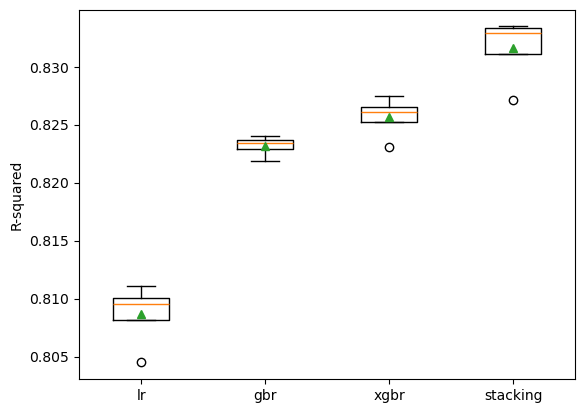

In [11]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.ylabel("R-squared")
pyplot.show()

## Model plots

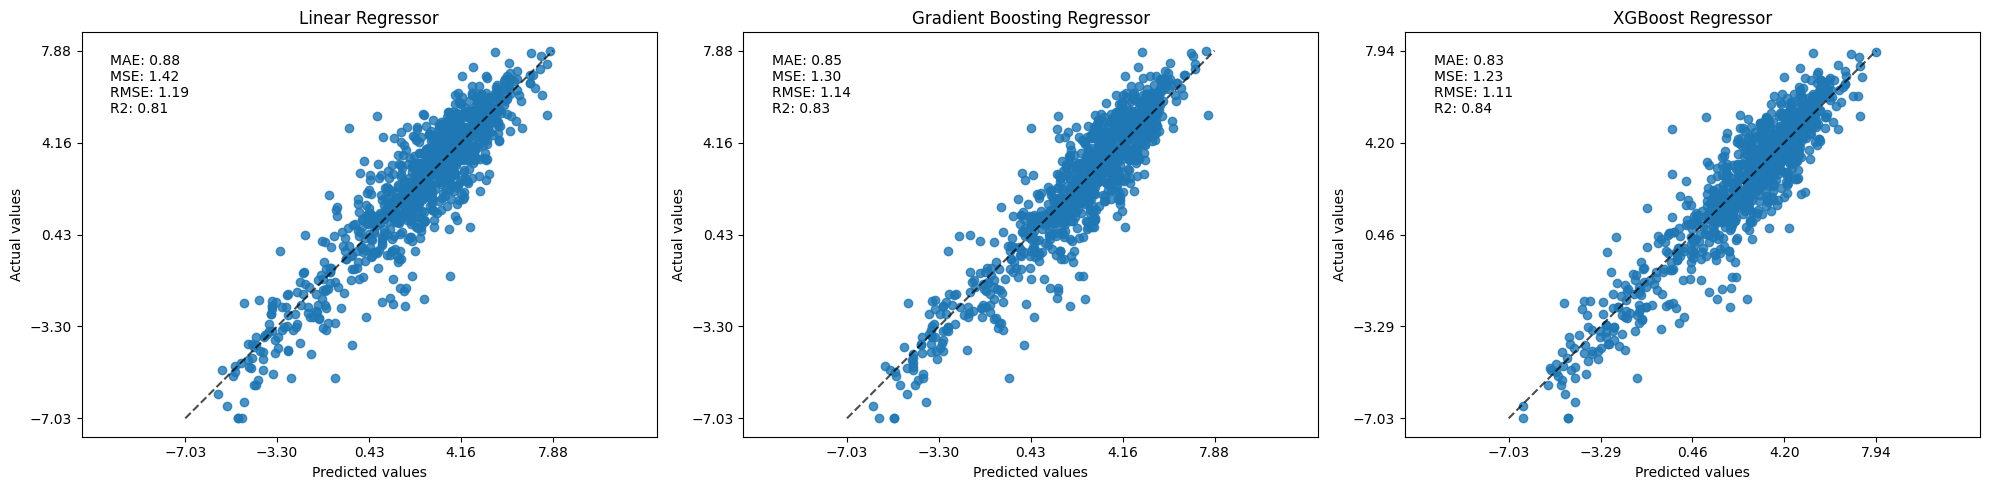

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Linear Regressor")
axs[0].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_lr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}\nR2: {r2_score(y_test, y_pred_lr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_gbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Gradient Boosting Regressor")
axs[1].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_gbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_gbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbr)):.2f}\nR2: {r2_score(y_test, y_pred_gbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_xgbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[2],
    random_state=0,
)
axs[2].set_title("XGBoost Regressor")
axs[2].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_xgbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_xgbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgbr)):.2f}\nR2: {r2_score(y_test, y_pred_xgbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

# fig.suptitle("")
plt.tight_layout()
plt.show()

## SHAP analysis

[18:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


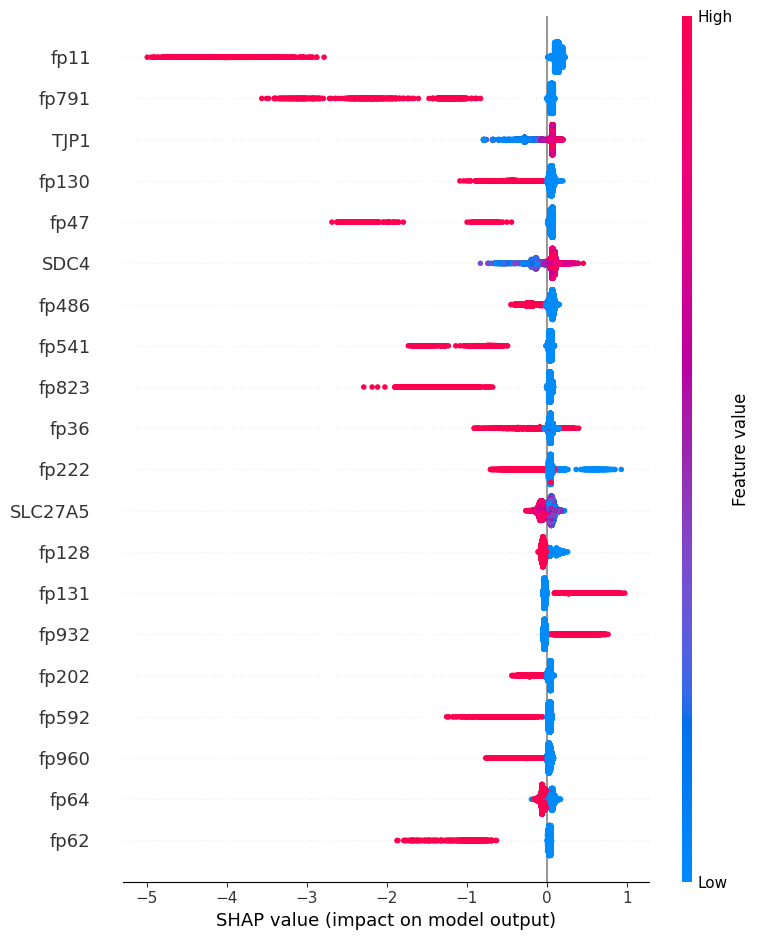

In [17]:

import shap
# SHAP analysis
explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(x_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, x_test, feature_names=x_train.columns)
